# FastAI Machine Learning 1 -- Random Forests

CodeAlong / Reimplementation of: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb

Lessons 1 & 2

## 1.2 Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/bulldozers/"

In [4]:
!ls {PATH}

Data Dictionary.xlsx             Valid.csv
Machine_Appendix.csv             ValidSolution.csv
Test.csv                         median_benchmark.csv
Train.csv                        random_forest_benchmark_test.csv


## 2. Data

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False,
                     parse_dates=["saledate"])

In any sort of analytics work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [7]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [8]:
display_all(df_raw.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Lecture 2 00:06:08](https://youtu.be/blyXCk4sgEg?t=368) It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of project setup. However, in this case Kaggle tells us what metric to use: RMSLE (Root Mean Squared Log Error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

$$\sum\big((\ln{(acts)} - \ln{(preds)})^2\big)$$

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### 2.2.2 Initial Processing

In [10]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

From the error above, we see we need all our columns to be numbers.

We'll start off by replacing the date ('saledate') column with a whole bunch of date-related columns.

In [11]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

We can see those new date columns below where 'saledate' used to be:

In [12]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


The new date columns are numbers, but:

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to Pandas categories. 

In [13]:
train_cats(df_raw)

In [14]:
df_raw.UsageBand

0            Low
1            Low
2           High
3           High
4         Medium
5            Low
6           High
7           High
8            Low
9         Medium
10        Medium
11           Low
12           NaN
13        Medium
14           Low
15        Medium
16           Low
17           NaN
18           Low
19        Medium
20        Medium
21        Medium
22           Low
23          High
24        Medium
25        Medium
26           Low
27           NaN
28           Low
29        Medium
           ...  
401095       NaN
401096       NaN
401097       NaN
401098       NaN
401099       NaN
401100       NaN
401101       NaN
401102       NaN
401103       NaN
401104       NaN
401105       NaN
401106       NaN
401107       NaN
401108       NaN
401109       NaN
401110       NaN
401111       NaN
401112       NaN
401113       NaN
401114       NaN
401115       NaN
401116       NaN
401117       NaN
401118       NaN
401119       NaN
401120       NaN
401121       NaN
401122       N

At first glance it doesn't look like anything's changed, but if you take a deeper look, you'll see the data type has changed to 'category'. 'category' is a Pandas class, with attributes accesible via `.cat.xxxx`

The index below shows that 'High' --> 0, 'Low' --> 1, 'Medium' --> 2

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [16]:
# we can do .cat.codes to get the actual numbers
df_raw.UsageBand.cat.codes

0         1
1         1
2         0
3         0
4         2
5         1
6         0
7         0
8         1
9         2
10        2
11        1
12       -1
13        2
14        1
15        2
16        1
17       -1
18        1
19        2
20        2
21        2
22        1
23        0
24        2
25        2
26        1
27       -1
28        1
29        2
         ..
401095   -1
401096   -1
401097   -1
401098   -1
401099   -1
401100   -1
401101   -1
401102   -1
401103   -1
401104   -1
401105   -1
401106   -1
401107   -1
401108   -1
401109   -1
401110   -1
401111   -1
401112   -1
401113   -1
401114   -1
401115   -1
401116   -1
401117   -1
401118   -1
401119   -1
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

To actually use this dataset and turn it into numbers, what we need to do is to take every categorical column and replace it with `.cat.codes`

This is done further below in 2.2.3 Pre-processing via `proc_df()`

In [17]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [18]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [19]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [20]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw.feather')

### 2.2.3 Pre-processing

The `nas` coming out of `proc_df()` is a dictionary, where the keys are the names of columns with missing values, and the values are the medians.

Optionally you can pass `nas` as an additional arg to `proc_df()`, and it'll make sure it adds those specific columns and uses those specific medians. IE: it gives you the ability to say "process this test set exactly the same way we processed the training set." [FAML1-L3: 00:07:00](https://youtu.be/YSFG_W8JxBo?t=420)

In [19]:
# df_raw = pd.read_feather('tmp/bulldozers-raw.feather')

In [21]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [22]:
??numericalize

In [22]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

The R^2 score shown below shows the variance (or mean?) of the data. It shows how much the data varies.

In [23]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9830736295528424

A validation set helps handle the issue of overfitting. Make it st it shares the test set's properties, ie: give it 12k rows just like the test set, and split it as the first n - 12k rows for training and the last 12k rows as validation set.

In [24]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as Kaggle's test set size
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

> [Lecture 2 00:17:58](https://youtu.be/blyXCk4sgEg?t=1078) Creating your validation set is *the* most important thing [I think] you need to do when you're doing a Machine Learning project – at least in terms of the actual modeling part.

A Note on the validation set: in general any time you're building a model that has a time element, you want your test set to be a separate time period -- and consequently your validation set too. In this case the dataset is already sorted by date, so you can just take the later portion.

# 3. Random Forests

## 3.1 Base Model

Let's try our model again, this time with separate training and validation sets.

In [25]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [26]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 26s, sys: 757 ms, total: 1min 26s
Wall time: 28.1 s
[0.09037981927504621, 0.24910070735054313, 0.9829282609692384, 0.8891851671988666]


Here we see our model, which had 0.982 R2 on the training set, got only 0.887 on the validation set, which makes us think it's overfitting quite badly. However it's not too badly because the RMSE on the logs of the prices (0.25) would've put us in the top 25% of the competition anyway (100/407).

\**reran this on another machine*

## 3.2 Speeding things up

Fast feedback is important for iteration and good interactive analysis. To this end we can pass in the `subset` par to `proc_df()` which'll randomly sample the data. We want no more than a 10sec wait when experimenting.

When you do this you still have to be careful your validation set doesn't change, and your training set doesn't overlap with it. So after sampling 30k items, we'll then taken the first 20k (since they're sorted by date) for our training data, and ignore the other 10k -- keeping our validation set the same as before.

In [27]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [28]:
m = RandomForestRegressor(n_jobs=-1) # n_jobs=-1: set to num. cores on CPU
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3 s, sys: 34.2 ms, total: 3.04 s
Wall time: 1.02 s
[0.11341341994618517, 0.36452654006502616, 0.9720144558108447, 0.7626953321976756]


Instead of 83 seconds of total compute time (15.2s thanks to multi-cores), we now run in only 2.94 total seconds of compute.

## 3.3 Single tree

Let's use that subset to build a model that's so simple we can actually take a look at it. We'll build a forest made of trees - and before we look at the forest, we'll look at the trees.

In scikit-learn the trees are called 'estimators'. Below we'll make a forest with a single tree `n_estimators=1`, and a small tree at that `max_depth=3`, and we'll turn off the random-component of the RandomForest `bootstrap=False`. Now it'll create a small deteriministic tree.

In [29]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5210881957762648, 0.5816324132398821, 0.4092178929355186, 0.39584944914074127]


After fitting the model and printing the score, the R2 score has dropped from 0.77 to 0.39. This is *not* a good model. It's better than the Mean-model (being > 0) but still not good.

But we can draw this model to take a look at it:

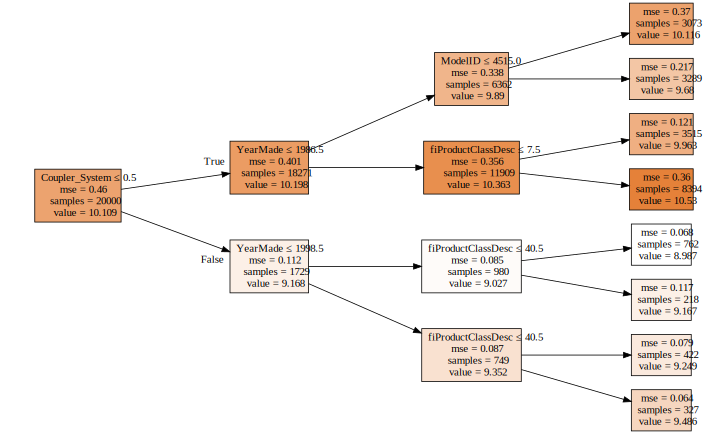

In [30]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [31]:
df_raw.fiProductClassDesc.cat.categories

Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
       'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
       'Backhoe Loader - Unidentified',
       'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
       'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
       'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
       'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
       'Hydraulic Excavator, Track - 150.0 to 300.0 Metric Tons',
       'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
       'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
       'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
       'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
       'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
       'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 

In [57]:
# df_raw.fiProductClassDesc.cat.codes

A tree is a series of binary decisions, or splits. Our tree first of all decided to split on `Coupler_System ≤ 0.5`. That's actually a boolean variable, True/False. Within the group where it was True, it further split those into `YearMade ≤ 1988` (1987.5), and on, etc.

Looking at our tree, in the first box: there are 20,000 rows in our data set (samples), the average of the log of price is 10.1, and if we built a model where we just used that average all the time: then the mean-squared-error would be 0.456.

So this first box is like the Denominator of an R^2. The most basic model is a tree with zero splits, just predict the average.

It turns out above that the best single binary split we can make turns out to be splitting by where the Coupler System is ≤ 0.5. (True or False).

If we do that, the MSE of Coupler System < 0.5 (ie: False) goes down from 0.456 to 0.111, improving the error a lot. In the other group, it's only improved slightly, from 0.456 to 0.398.

We can also see the Coupler System False group is only a small percentage: 1,721 samples of the total 20,000.

---

If you wanted to know what the single best binary decision to make for your data, how could you do it?

We want to build a Random Forest from scratch.

The first step is to create a tree. The first step to creating a tree is to create the first binary decision. *How do you do this*?

[FAML1-0:39:02](https://youtu.be/blyXCk4sgEg?t=2342)

Enumerate the different splits for each variable and choose the one with the lowest MSE. *so how do we do the enumeration?*

For each variable, for each possible value of that variable: see if its better. *What does better mean?:*

We could take the weighted average of the new MSE times number of samples.

That would be the same as saying: 
> I've got a model. The model is a single binary decision. For everybody with YearMade ≤ 1987.5, I'll fill-in 10.21, for everyone > 1987.5 I'll fill-in 9.184, and calculate the RMSE of this model.

That'll give the same answer as the weighted-average idea.

So now we have a single number that represents how good a split is: the weighted average of the MSE's of the two groups it creates.

We also have a way to find the best split, which is to try every variable, and every possible value of that variable, and see which variable and which value gives us a split with the best score.

---

The granuality is defined by the variables. So, `Coupler_System` only has two possible values, True or False. `YearMade` ranges from 1960 to 2010, so we just try all those unique values. All those possible split points.

Now rinse and repeat: with the conditions set by the split: continue.

*Claim*: it's **Never** necessary to do more than 1 split at a level

*Why?*: because you can split it again.

***THAT*** is the entirety of creating a Decision Tree. You stop either when you hit some requested limit (here when depth reaches 3), or when the leaf-nodes each only contain 1 thing.

That is how we grow decision trees.

---

Now this tree isn't very good, it has a validation R^2 of 0.39. We can try to make it better by letting grow deeper (removing `max_depth=3`

Bigger tree:

In [33]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.329070518200751e-17, 0.48822155887352336, 1.0, 0.5743213387002792]


If we don't limit depth, the training R^2 is of of course, a perfect 1.0. Because we can exactly predict every training element because it's in a leaf-node all it's own.

But the validation R^2 is not 1.0. It's a lot better than our super-shallow tree, but not as good as we'd like.

We want to find another way of making these trees better. And we'll do that by making a forest.

*What's a forest?*

To create a forest we're going to use a statistical technique called *bagging*.

## 3.4 Bagging

### 3.4.1 Intro to Bagging

You can bag any kind of model. The Random Forest is a way of bagging Decision Trees.

Bagging: what if we created 5 different models, each of which was only somewhat predictive, but the models weren't at all correlated with each other -- their predictions weren't correlated. That would mean the 5 models would've had to've found different insights into relationships in the data.

If you took the average of those models, you're effectively taking in the insights from each of them.

Averaging models: **Ensembling**.

Let's come up with a more specific idea of how to do this. What if we created a hole lot of these trees: big, deep, massively-overfit D-Trees. But each tree gets a random 1/10th of the data. And do that a hundred times with different random samples.

All the trees will have errors, but random errors. What's the average of a bunch of random errors? Zero. So if we take the average the error will average to zero and what's left is the true relationship.

*That's* a **Random Forest**.

---

After making those trees, we'll take our test data, run it through the tree, get to the leaf node, take the average in that leaf node for all the trees, and average them all together.

To do that we call `RandomForestRegressor(.)`. An 'estimator' is what scikit-learn calls a tree. By default `n_estimators = 10`

In [34]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11075902671356637, 0.3726132471714873, 0.9733091057530973, 0.7520497469863333]


We'll grab the predictions for each individual tree, and look at one example.

Each tree is stored in the attribute: `.estimators_`. Below gives a list of arrays of predictions. Each array will be all the predictions for that tree.

`np.stack(.)` concatenates them on a new axis.

In [35]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.4727 , 9.3501 , 9.15905, 9.61581, 8.9872 , 9.18502, 9.04782, 9.25913, 9.04782, 8.92266]),
 9.204731061374869,
 9.104979856318357)

We see a shape of 10 different sets of predictions and for each one our validation set of size 12,000 -- so 12,000 predictions for each of the 10 trees:

In [37]:
preds.shape

(10, 12000)

Above, `preds[:,0]` returns an array of the first prediction for each of our 10 trees. `np.mean(preds[:,0])` returns the mean of those predictions, and `y_valid[0]` shows the actual answer. Most of our trees had inaccurate predictions, but the mean of them was actually pretty close.

*Note: I probably made a mistake somewhere - or the data was too small - for multiple trees getting the exact answer*

The models are based on different random subsets, and so their errors aren't correlated with eachother. The key insight here is to construct multiple models which are better than nothing, and the errors are - as much as possible - not correlated with eachother.

One of our first tunable hyperparameters is our number of trees.

What scikit-learn does by default is for N rows it picks out N rows with replacement: **bootstrapping**. ~ 63.2% of the rows will be represented, and a bunch of them multiple times.

The whole point of Machine Learning is to identify which variables matter the most and how do they relate to each other and your dependant variable together.

Random Forests were discovered/invented with the aim of creating trees as predictive and as uncorrelated as possible -- 1990s. Recent research has focused more on minimizing correlation: creating forests with trees that are individually less predictive, but with very little correlation.

There's another scikit-learn class called:

    sklearn.ensemble.ExtraTreesClassifier 
or 

    sklearn.ensemble.ExtraTreesRegressor
    
With the exact same API (just replace `RandomForestRegressor`). It's called an "Extremely Randomized Trees" model. It does exactly what's discussed above, but instead of trying every split of every variable, it randomly tries a few splits of a few variables.

So it's much faster to train, and has more randomness. With the time saved, you can build more trees - and therefore get better generalization.

In practice: if you have crappy individual trees, you just need more models to get a good overall model.

---

Now the obvious question: isn't this computationally expensive? Going through every possible value of a 32-bit Float or .. God forbid.. a 64-bit Float? *Yes*. 

Firstly, that's why it's good your CPU runs in GHz, billions of clock-cycles per second, and moreso why Multi-Core processors are fantastic. Each core has SIMD capability -- *Single Instruction Multiple Data* -- allowing it to perform up to 8 computations at once - and that's *per core*.

On the GPU performance is measured in TFLOPS - Terra FLOPS - *Trillions of FLoating Point Operations per Second*.

*This is why, when designing Algorithms, it's very difficult for us Humans to realize how * ***stupid*** *algorithms* ***should be*** *given how fast modern computers are.*

It's quite a few operations... but at trillions per second, you hardly notice it.


Let's do a little data analysis. Let's go through each of the 10 trees, take the mean of all the predictions up to the ith tree and plot the R^2:

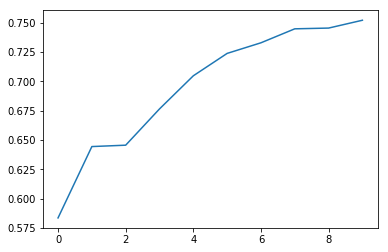

In [39]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Note that the final value on the plot is the same as the final R^2 score returned by the RandomForest -- about 0.7748 here.

The shape of this curve suggests that adding more trees isn't going to help much. Let's check (Compare this to our original model on a sample).

In [40]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10258662444339031, 0.3509520962080402, 0.9771025909476682, 0.7800400281094578]


In [41]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09745396221449659, 0.3510083799404639, 0.9793365009240559, 0.7799694705543578]


In [42]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 25.6 s, sys: 342 ms, total: 25.9 s
Wall time: 8.83 s
[0.09475491978613247, 0.35148360227815534, 0.9804652256199156, 0.7793732784884282]


In [43]:
m = RandomForestRegressor(n_estimators=160, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 51.5 s, sys: 629 ms, total: 52.1 s
Wall time: 17.1 s
[0.09335473170490244, 0.350923572240219, 0.9810382885530835, 0.7800757815713117]


*At this point, it looks like we're inside signal noise. More trees is never going to make the model* ***worse*** *- but a lower score is easily explained as whatever diminished accuracy gain being overwhelmed by noise in the random-sampling of the data.*

If that's the case, I'd expect being able to see an R2 score greater than 0.79786, with the same hyperparameters:

In [58]:
m = RandomForestRegressor(n_estimators=160, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 49.7 s, sys: 28 ms, total: 49.8 s
Wall time: 6.44 s
[0.09350422410741205, 0.331284137778844, 0.9809465308457207, 0.80400307496828338]


Well there you have it. And the highest score so far to boot.

The `n_estimators` hyperparameter is a tradeoff between improvement vs. computation time.

Interesting note above, number of trees increases computation time ***Linearly***.

You can still get many of the same insights as a large forest, with a few dozen trees, like 20 or 30.

### 3.4.2 Out-of-Bag (OOB) Score

Is our validation set worse than our training set because we're overfitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, Random Forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

---

So what if your dataset is so small you don't want to pull anything out for a validation set - because doing so means you no longer have enough data to build a good model? What do you do?

There's a cool trick unique to Random Forests. We could recognize that for each tree there are some portion of rows not used... So we could pass in the rows not used by the 1st tree to the 1st, the rows not used by the 2nd to the 2nd, and so on. So technically we'd have a different validation set for each tree. To calculate our prediction, we would average all of the trees where that row was not used for training.

As long as you have enough trees, every row is going to appear in the OOB sample for one of them at least. So you'll be averaging a few trees - more if you have more trees.

You can create an OOB prediction by averaging all the trees you didn't use to train each individual row, and then calculate RMSE, R2, etc, on that.

If you pass `oob_score=True` to scikit-learn, it'll do that for you. It'll then create an attribute `oob_score_`. Our `print_score(.)` function at top prints out the oob score if it exists.

In [44]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09796186615774606, 0.3528143060936967, 0.9791205544160546, 0.7776995470461441, 0.8518228978081674]


The extra value at the end is the R2 for the oob score. We want it to be very close to the R2 for the validation set (2nd to last value) although that doesn't seem to be the case here.

In general the OOB R2 score will slightly underestimate how generalizable the model is. The more trees you have, the less it'll be less by.

Although in this case my OOB R2 score is actually better than my validation R2... **NOTE** ([L2 1:21:54](https://youtu.be/blyXCk4sgEg?t=4914)) the OOb score is better because it's taken from a random sample of the data, whereas our validation set is not: it's a different time-period which is harder to predict.

---

The OOB R2 score is handy for finding an automated way to set hyperparameters. A Grid-Search is one way to do this. You pass in a list of all hyperpars you want to tune to scikit-learn and a list of all values you want to try for each hypar, and it'll run your model on every possible combination and tells you which one is best. OOB score is a great choice for measuring that.

## 3.5 Reducing Over-Fitting

### 3.5.1 Subsampling [Lecture 2 1:14:48](https://youtu.be/blyXCk4sgEg?t=4488)

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique. [1:15:00]

What we did before wasn't ideal. We took a subset of 30k rows of the data, and built our models on that - meaning every tree in our RF is a different subset of that subset of 30k. Why? Why not pick a totally different subset of 30k for each tree. So leave the total 300k dataset as is, and if we want to make things faster, pick a different subset of 30k each time. Instead of bootstrapping the entire set of rows, let's just randomly sample a subset of the data.

Let's do that by calling `proc_df()` without the subset par to get all our data. 

In [45]:
n_trn

389125

In [46]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [47]:
len(df_trn), len(X_train)

(401125, 389125)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree, it'll be just as fast as if we'd cut down our dataset as before.

When we run `set_rf_samples(20000)`, when we run a RF, it's not going to bootstrap an entire set of 390k rows, it's going to grab a subset of 20k rows.

So when running, it'll be just as fast as when we did a random sample of 20k, but now every tree can have access to the entire dataset. So if we have enough estimators/trees, the model will eventually see everything.

In [48]:
set_rf_samples(20000)

In [49]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.59 s, sys: 623 ms, total: 10.2 s
Wall time: 5.91 s
[0.24053144354918343, 0.2786822479286957, 0.8790854562443459, 0.8613031543839028, 0.8663816576319365]


We don't see that much of an improvement over the R2 with the 20k data-subset, because we haven't used many estimators yet.

Since each additional tree allows th emodel to see more data, this approach can make additional trees more useful. 

In [50]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 35.7 s, sys: 1.6 s, total: 37.3 s
Wall time: 18.6 s
[0.22688754554867838, 0.2629384558384796, 0.8924139060853161, 0.8765314948185428, 0.8809418778112746]


With more estimators the model can see a larger portion of the data, and the R2 (2nd last value) has gone up from 0.8591 to 0.8755.

The Favorita groceries competition has over a hundred-million rows of data. There's no way you'll create an RF using 128M rows in every tree. It'll take forever. Instead you can use `set_rf_samples(.)` set to 100k or 1M.

The trick here is with a Random Forest using this technique, no dataset is too big. Even if it has 100B rows. You can just create a bunch of trees, each with a different subset.

***NOTE***: right now OOB Scores and `set_rf_samples(.)` are not compatible with each other, so you need to set `oob_score=False` if you use `set_rf_samples(.)` because the OOB score will be meaningless.

To turn of `set_rf_samples(.)` just call: `reset_rf_samples()`

---

A great big tip - that very few people in Industry or Academia use:

Most people run all their models on all their data all the time using their best possible pars - which is just pointless.

If you're trying to find which features are important and how they relate to oneanother, having that 4th dec place of accuracy isn't going to change anything.

Do most of your models on a large-enough sample size that your accuracy is reasonable (within a reasonable distance of the best accuracy you can get)  and it's taking a few seconds to train - so you can do your analysis.

### 3.5.2 Tree Building Parameters

We revert to using a full bootstrap sample in order to show the impact of the other over-fitting avoidance methods.

In [51]:
reset_rf_samples()

Let's get a baseline for this full set to compare to. This'll train 40 estimators all the way down until the leaf nodes have just one sample in them.

In [52]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07833656982792957, 0.2365621009575368, 0.9871748064512288, 0.9000602379276964, 0.9087597511625408]


This gets us a 0.899 R2 on the validation set, or a 0.908 on the OOB.

[L2 1:21:54](https://youtu.be/blyXCk4sgEg?t=4914) Our OOB is better than our ValSet bc our ValSet is actually a different time period (future), whereas the OOB is a random sample. It's harder to predict the future.

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

* There are less decision rules for each leaf node; simpler models should generalize better.

* The predictions are made by average more rows in the leaf node, resulting in less volatility.

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 28s, sys: 3.35 s, total: 5min 32s
Wall time: 1min 52s
[0.11506247362429046, 0.23550660904958062, 0.9723304409167105, 0.9009500700865379, 0.9084500693422777]


Setting `min_samples_leaf = 3` stops the RF when each leaf-node has 3 or fewer samples in it. In practice this means 1 or 2 fewer levels of decisions being made - which means around half the number of decision criteria, so it'll train much quicker. It also means when we look at an individual tree, instead of taking one point, wer're taking the average of 3 points - so we'd expect the trees to generalize better, though each tree is likely to be less powerful than before.

Values of in the range of 1, 3, 5, 10, 25 tend to work well for `min_samples_leaf`.

If you have a massive dataset and aren't using small samples, you may need a `min_samples_leaf` in the hundreds or thousands.

In this case, going from the default leaf-size of 1 to 3 has increased our valset R2 from 0.899 to 0.903.

We can also increase the amount of variation amongst the trees by not only using a sample of rows for each tree, but also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

Idea: the less correlated your trees are with eachother: the better. Image you had 1 column that was so much better than all the other cols at being predictive, that every tree you built - regardless of which subset of rows - always started with that column. So the trees are all going to be pretty similar. But you can imagine there being some interaction of variables where that interaction is more important than that individual column. 

So if each tree always splits on the same thing the first time, you're not going to get much variation on those trees.

So what we do in addition to just taking a subset of those rows, is at every single split point take a different subset of columns.

This is slightly different to the row sampling. In row-sampling, each new tree is based on a random set of rows. In column sampling every individual binary split chooses from a different subset of columns.

IoW: rather than looking at every possible level of every possible column, we look at every possible level of a random subset of columns. And at each decision point we use a different random subset. 

*How many?* You get to pick. `max_features=0.5` means you choose half of them. The default is to use all.

J.Howard has found good values at: 1, 0.5, Log(2), Sqrt()

---

***NOTE*** the RF never *removes* variables as it's building a Decision Tree. It just goes through the different split points based on possible values.

---

You may have noticed our RMSE of Log(price) has been dropping on our validation set as well (2nd value), now down to 0.23306.

Checking the public leaderboard, `0.23305579` gets us to 25th place. Unfortunately the competition is old enough that direct comparisons are difficult, but we get the general idea.

Roughly speaking, we'd've gotten in the top 25 of this competition with a brainless Random Forest with some brainless hyperparameter tuning.

*This is why the Random Forest is such an important first step, and often * ***only*** *step in Machine Learning.*

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11920885040218751, 0.22881458675998287, 0.9703003161863657, 0.9064991868346864, 0.9114375631726012]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer submit to this competition) – but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees – as you see, using subset of features on each split requires using more trees, but results in better models.

<p><img src = "https://camo.githubusercontent.com/c9bf9157ef5dbe0b0ea9ad4cbb87a5e42ca03c18/687474703a2f2f7363696b69742d6c6561726e2e6f72672f737461626c652f5f696d616765732f737068785f676c725f706c6f745f656e73656d626c655f6f6f625f3030312e706e67"/></p>

## End

---